In [20]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

# Graphic libraries

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1)
import seaborn as sns

import pystan
import stan_utility


In [2]:
def light_curve(time, idx1, peak_flux, peak_time, idx2):
    
    
    out = np.zeros_like(time)
    idx = time <= peak_time
    
    out[idx] = np.power(time[idx]/peak_time, idx1)
    out[~idx] = np.power(time[~idx]/peak_time, idx2)
    
    return out * peak_flux
    
    
    
    
    

In [3]:
time = np.logspace(0, 3,500)

lc = light_curve(time, idx1=0., peak_flux=100., peak_time=100., idx2=-2)



<IPython.core.display.Javascript object>


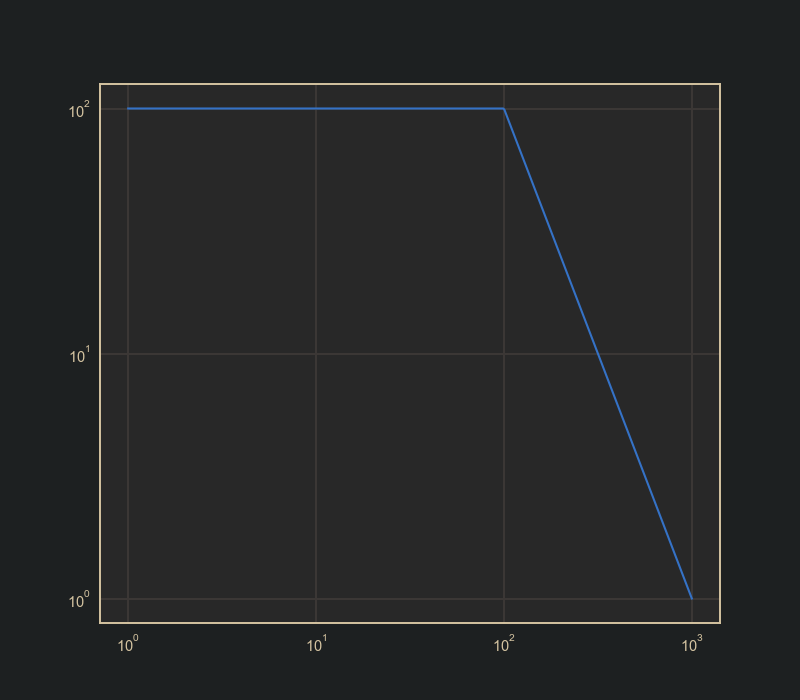

In [4]:
fig, ax = plt.subplots()

ax.loglog(time, lc)

In [30]:
def draw_lightcurve(time, idx1, peak_flux, peak_time, idx2, flux_sigma, cal_mu, cal_sigma):
    
    # first we sample from the calibration star
    
    calibration = np.random.normal(cal_mu, cal_sigma)
    
    # now sample the light curve assuming that we have measured
    # fluxes, not counts
    
    lc_true = light_curve(time, idx1, peak_flux, peak_time, idx2)
    
    measured_fluxes = np.random.normal(loc=lc_true, scale=flux_sigma, size=len(time))
    
    n_model = 100
    time_model = np.logspace(1,3, n_model)
    
    data = dict(N=len(time),
                time = time,
                flux_obs = measured_fluxes + calibration,
                flux_sigma = flux_sigma,
                calibration=calibration,
                N_model = n_model,
                time_model = time_model,
                calibration_mu = cal_mu,
                calibration_sigma = cal_sigma
               )
    
    return data
    
    
    
    
    

In [7]:
time = np.sort(10**(np.random.uniform(0,3, size=10)))

data = draw_lightcurve(time, idx1=0, peak_flux=100, peak_time=100, idx2=-2, flux_sigma=5., cal_mu = 10, cal_sigma=5)

In [8]:
def plot_data(data, ax=None, **kwargs):
    
    if ax is None:
        
        fig, ax = plt.subplots()
        
    else:
        
        fig = ax.get_figure()
        
    
    
    ax.errorbar(data['time'], data['flux_obs'], yerr=data['flux_sigma'], **kwargs )
    
    ax.set_xscale('log')
    
    ax.set_yscale('log')
    
    return fig
    
    

<IPython.core.display.Javascript object>


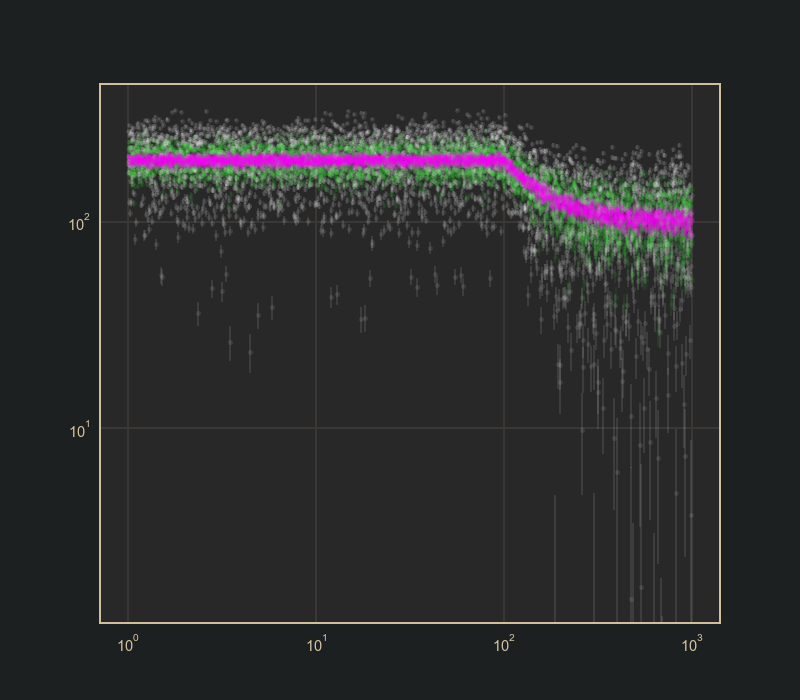

In [19]:
np.random.seed(123)
fig,ax = plt.subplots()




for i in range(500):
    time = np.sort(10**(np.random.uniform(0,3, size=10)))

    data = draw_lightcurve(time,
                           idx1=0, peak_flux=100, peak_time=100, idx2=-2, flux_sigma=5., 
                           cal_mu = 100, cal_sigma= 50)

    plot_data(data,ax=ax,fmt='.', alpha=.1, color='white');
    
    
    
for i in range(500):
    time = np.sort(10**(np.random.uniform(0,3, size=10)))

    data = draw_lightcurve(time,
                           idx1=0, peak_flux=100, peak_time=100, idx2=-2, flux_sigma=5., 
                           cal_mu = 100, cal_sigma= 25)

    plot_data(data,ax=ax,fmt='.', alpha=.1, color='limegreen');
    
    
    
for i in range(500):
    time = np.sort(10**(np.random.uniform(0,3, size=10)))

    data = draw_lightcurve(time,
                           idx1=0, peak_flux=100, peak_time=100, idx2=-2, flux_sigma=5., 
                           cal_mu = 100, cal_sigma= 5)

    plot_data(data,ax=ax,fmt='.', alpha=.1, color='magenta');

In [92]:
np.random.seed(34532)
time = np.sort(10**(np.random.uniform(0,3, size=10)))

data = draw_lightcurve(time, 
                       idx1=0, peak_flux=100, peak_time=100, idx2=-2, flux_sigma=10.,
                       cal_mu = 100, cal_sigma=25)

In [93]:
model_full = stan_utility.compile_model('lightcurve_full.stan')

Using cached StanModel


In [94]:
fit_full = model_full.sampling(data=data,iter=2000,seed=3563453)

/Users/jburgess/.environs/stan/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


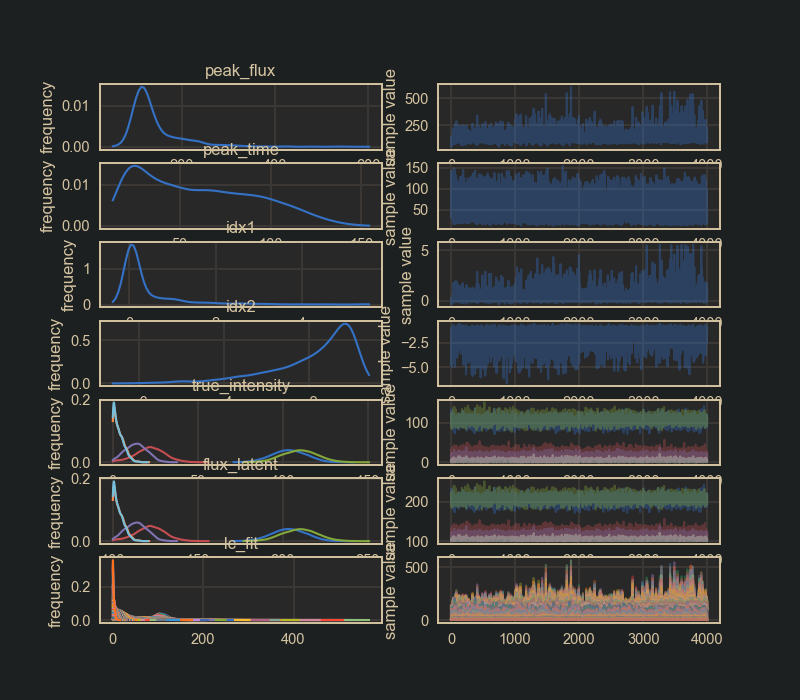

In [95]:
fit.plot();

<IPython.core.display.Javascript object>


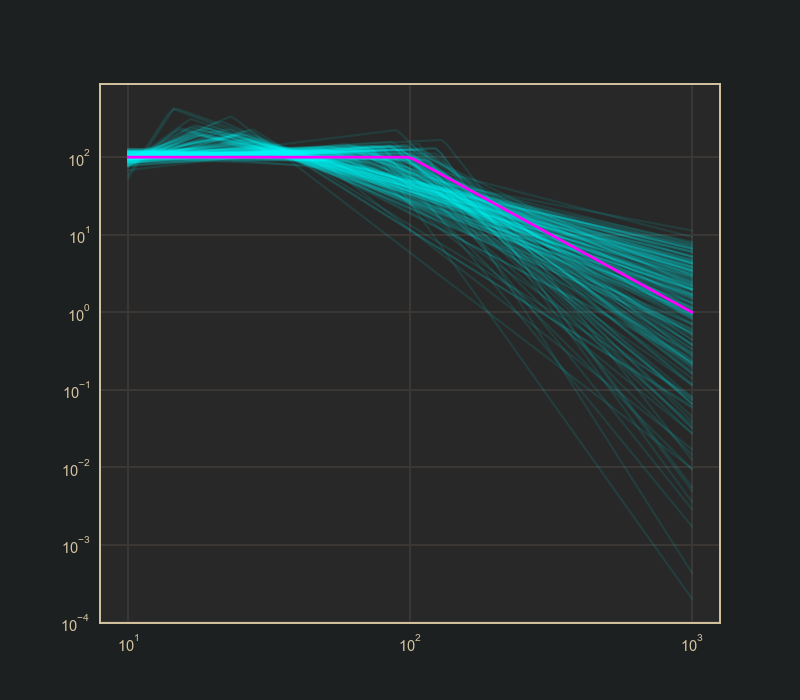

In [96]:
fig, ax = plt.subplots()

for lc in fit.extract()['lc_fit'][::20]:
    
    
    ax.loglog(data['time_model'], lc, color='cyan', alpha=0.1)


ax.loglog(data['time_model'],
          light_curve(data['time_model'], idx1=0, peak_flux=100., peak_time=100, idx2=-2), color='magenta', lw=2 )

In [97]:
model = stan_utility.compile_model('lightcurve_simple.stan')

Using cached StanModel


In [98]:
fit = model.sampling(data=data,iter=2000,seed=3563453)

/Users/jburgess/.environs/stan/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


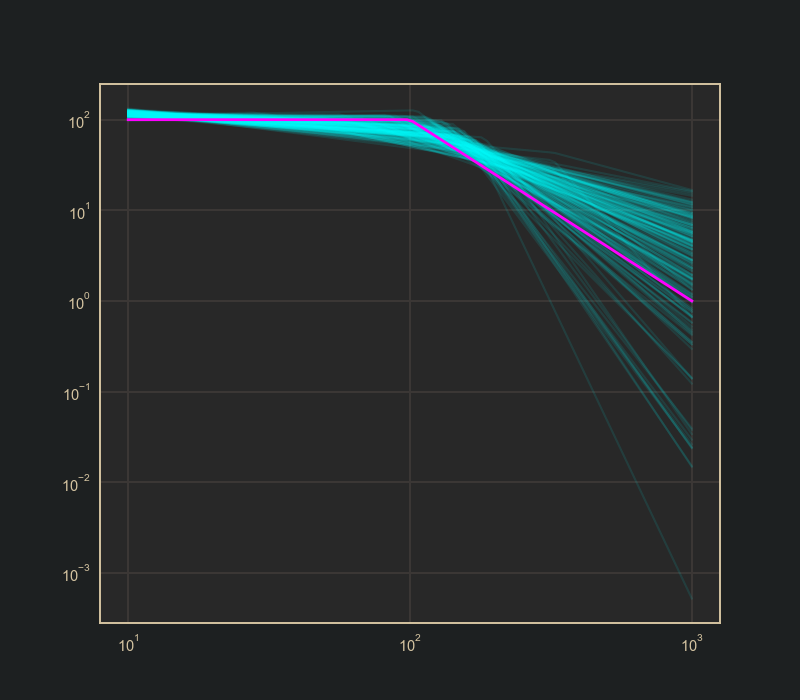

In [99]:
fig, ax = plt.subplots()

for lc in fit.extract()['lc_fit'][::20]:
    
    
    ax.loglog(data['time_model'], lc, color='cyan', alpha=0.1)


ax.loglog(data['time_model'],
          light_curve(data['time_model'], idx1=0, peak_flux=100., peak_time=100, idx2=-2), color='magenta', lw=2 )

<IPython.core.display.Javascript object>


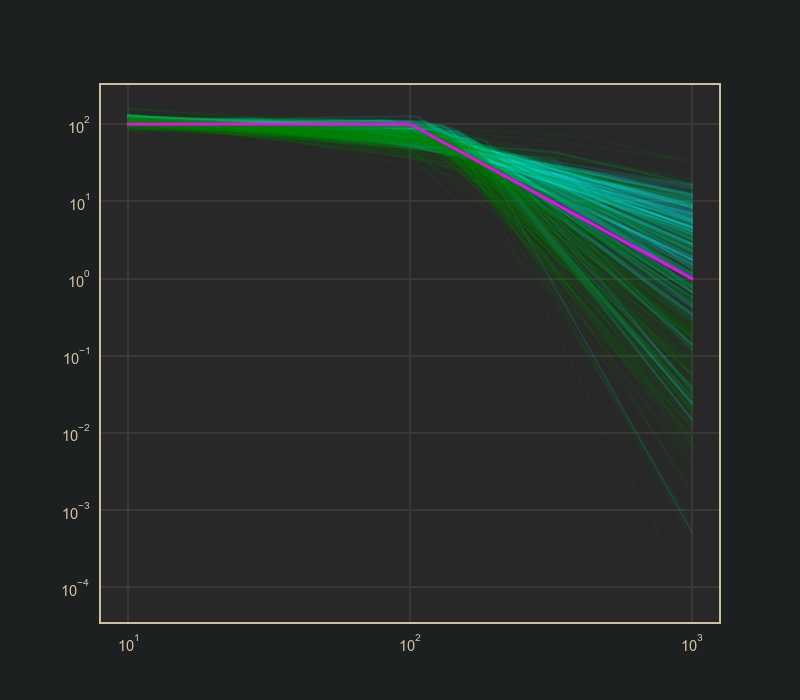

In [100]:
fig, ax = plt.subplots()

for lc in fit.extract()['lc_fit'][::20]:
    
    
    ax.loglog(data['time_model'], lc, color='cyan', alpha=0.1)
    
    
for lc in fit_full.extract()['lc_fit'][::20]:
    
    
    ax.loglog(data['time_model'], lc, color='green', alpha=0.1)




ax.loglog(data['time_model'],
          light_curve(data['time_model'], idx1=0, peak_flux=100., peak_time=100, idx2=-2), color='magenta', lw=2 )

<IPython.core.display.Javascript object>


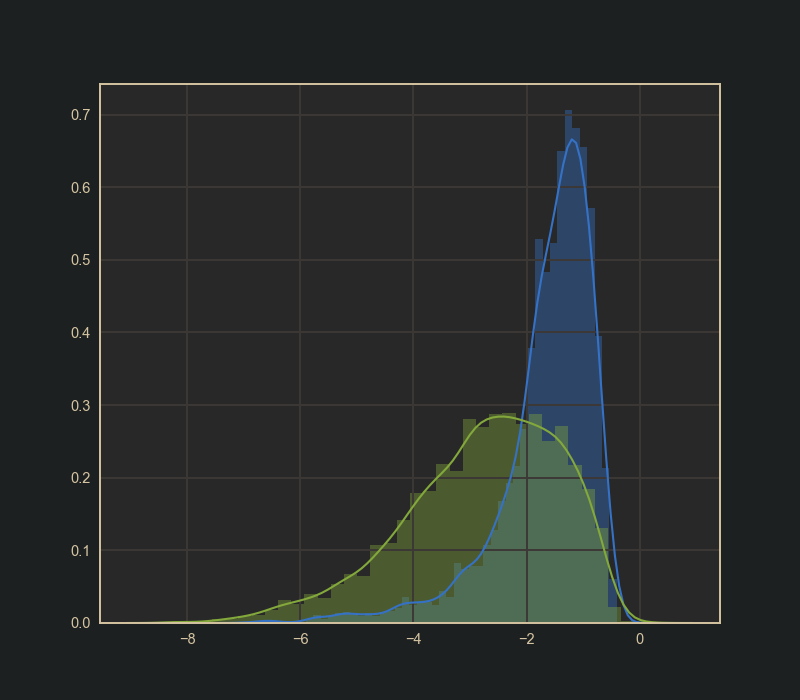

/Users/jburgess/.environs/stan/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [101]:
fig, ax = plt.subplots()


sns.distplot(fit.extract()['idx2'])

sns.distplot(fit_full.extract()['idx2'])

<IPython.core.display.Javascript object>


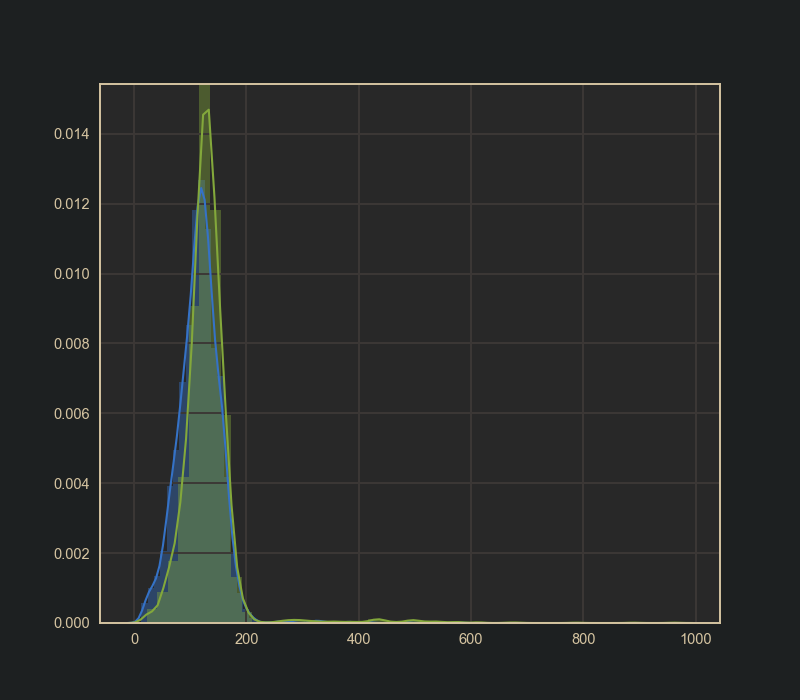

/Users/jburgess/.environs/stan/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [102]:
fig, ax = plt.subplots()


sns.distplot(fit.extract()['peak_time'])

sns.distplot(fit_full.extract()['peak_time'])